# Лабораторная работа 5 | Крючков А.В М80-407Б-21

## 2.1	Создание бейзлайна и оценка качества (регрссия)

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

### Загрузка и первичный анализ данных

In [118]:
data = pd.read_csv('data/insurance.csv')

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [119]:
# Преобразование категориальных признаков в числовые
label_encoder = LabelEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])
data['smoker'] = label_encoder.fit_transform(data['smoker'])
data['region'] = label_encoder.fit_transform(data['region'])

# Определение признаков и целевой переменной
X = data.drop('charges', axis=1)
y = data['charges']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

Среднеквадратичная ошибка (MSE): 18944595.16
Средняя абсолютная ошибка (MAE): 2447.95
Корень среднеквадратичной ошибки (RMSE): 4352.54
Коэффициент детерминации (R^2): 0.88


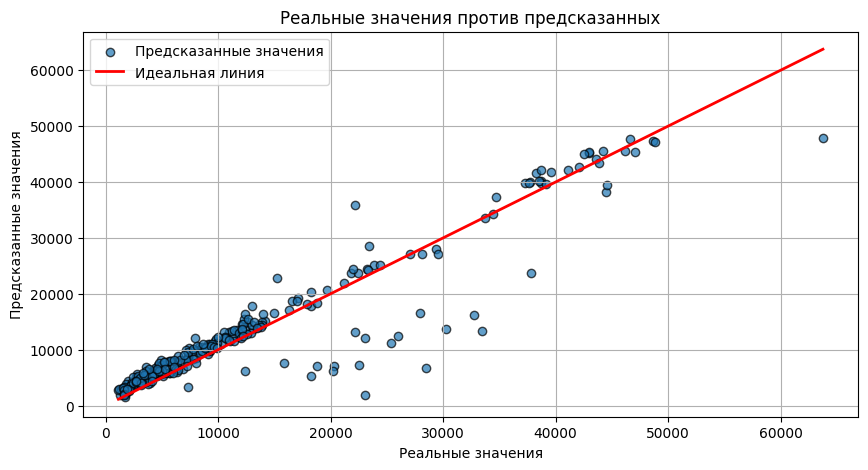

In [120]:
# Построение графика реальных значений против предсказанных
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k", label='Предсказанные значения')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Идеальная линия')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Реальные значения против предсказанных')
plt.legend()
plt.grid(True)
plt.show()

1. **Коэффициент детерминации (R² = 0.88):**
   - Модель объясняет 88% вариации целевой переменной (медицинские расходы), что говорит о высокой точности предсказаний. Оставшиеся 12% могут быть вызваны различными факторами, не учтенными в модели.

2. **Среднеквадратичная ошибка (MSE = 18,944,595.16):**
   - Это значение указывает на довольно большие ошибки в прогнозах, особенно из-за квадратичной природы ошибки. Однако, из-за особенностей медицинских расходов, такие отклонения могут быть ожидаемы.

3. **Корень среднеквадратичной ошибки (RMSE = 4,352.54):**
   - RMSE выражает ошибку в тех же единицах, что и целевая переменная, и показывает, что модель в среднем ошибается на сумму около 4352.54 единиц расходов. Это довольно приличная ошибка, но всё же она может быть приемлемой в некоторых контекстах.

4. **Средняя абсолютная ошибка (MAE = 2,447.95):**
   - MAE менее чувствительна к выбросам и в среднем показывает, что предсказания модели отклоняются от реальных значений на 2447.95 единиц расходов. Это также указывает на умеренную ошибку в прогнозах.

### Итог:
- Модель имеет хорошую предсказательную способность с высоким R², но RMSE и MAE показывают, что есть пространство для улучшений, особенно в учете выбросов или дополнительных факторов.

## 3.1	Улучшение бейзлайна (регрссия)

Проверим гипотезу, связанную с подбором гиперпараметров модели через кросс-валидацию

In [121]:
# Преобразование категориальных признаков в числовые
label_encoder = LabelEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])
data['smoker'] = label_encoder.fit_transform(data['smoker'])
data['region'] = label_encoder.fit_transform(data['region'])

# Определение признаков и целевой переменной
X = data.drop('charges', axis=1)
y = data['charges']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели
model = GradientBoostingRegressor(random_state=42)

# Определение гиперпараметров для GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],         # Количество деревьев
    'max_depth': [3, 5, 7],                  # Максимальная глубина дерева
    'learning_rate': [0.01, 0.1, 0.2],      # Скорость обучения
    'subsample': [0.8, 0.9, 1.0]             # Доля данных для обучения каждого дерева
}

# Использование GridSearchCV с кросс-валидацией
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print(f"Лучшие гиперпараметры: {grid_search.best_params_}")

# Прогнозирование на тестовых данных
y_pred = grid_search.best_estimator_.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

Лучшие гиперпараметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Среднеквадратичная ошибка (MSE): 18410744.19
Средняя абсолютная ошибка (MAE): 2422.62
Корень среднеквадратичной ошибки (RMSE): 4290.77
Коэффициент детерминации (R^2): 0.88


### До оптимизации:
- **Среднеквадратичная ошибка (MSE):** 18,944,595.16  
- **Средняя абсолютная ошибка (MAE):** 2,447.95  
- **Корень среднеквадратичной ошибки (RMSE):** 4,352.54  
- **Коэффициент детерминации (R²):** 0.88  

### После оптимизации:
- **Среднеквадратичная ошибка (MSE):** 18,410,744.19  
- **Средняя абсолютная ошибка (MAE):** 2,422.62  
- **Корень среднеквадратичной ошибки (RMSE):** 4,290.77  
- **Коэффициент детерминации (R²):** 0.88  

### Выводы:
1. **Качество модели осталось стабильным:**
   - Коэффициент детерминации (R²) остался на уровне **0.88**, что указывает на то, что модель по-прежнему объясняет 88% вариации целевой переменной.

2. **Небольшие улучшения в ошибках:**
   - MSE уменьшилось с **18,944,595.16** до **18,410,744.19** (около 500 тыс.), что указывает на некоторое улучшение точности модели.
   - MAE уменьшилось на **25.33** (с **2,447.95** до **2,422.62**), что также говорит о незначительном улучшении стабильности предсказаний.
   - RMSE уменьшилось на **61.77** (с **4,352.54** до **4,290.77**), что подтверждает улучшение средней ошибки в предсказаниях.

3. **Реализация гиперпараметрической оптимизации через GridSearchCV показала незначительное улучшение в метриках, что может свидетельствовать о хорошем изначальном состоянии модели, где дополнительные улучшения менее выражены.**

## 4.1	Имплементация алгоритма машинного обучения (регрссия)

In [122]:
class GradientBoostingRegressorCustom:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators   # Количество деревьев
        self.learning_rate = learning_rate  # Скорость обучения
        self.max_depth = max_depth          # Максимальная глубина деревьев

    def fit(self, X, y):
        # Инициализация модели (первоначальное предсказание)
        self.init_value = np.mean(y)  # Начинаем с предсказания среднего значения
        self.models = []  # Список для хранения моделей (деревьев)

        # Начальные предсказания
        residuals = y - self.init_value  # Ошибка, которую нужно минимизировать

        # Обучаем модель на каждом шаге
        for _ in range(self.n_estimators):
            model = DecisionTreeRegressor(max_depth=self.max_depth)  # Обучаем дерево
            model.fit(X, residuals)  # Обучаем на ошибках (residuals)
            pred = model.predict(X)  # Получаем предсказания
            residuals -= self.learning_rate * pred  # Корректируем ошибки

            self.models.append(model)  # Добавляем дерево в список моделей

    def predict(self, X):
        # Инициализация предсказаний с начального значения
        predictions = np.full(X.shape[0], self.init_value)

        # Объединяем предсказания всех деревьев
        for model in self.models:
            predictions += self.learning_rate * model.predict(X)  # Добавляем коррекцию

        return predictions

In [123]:
# Преобразование категориальных признаков в числовые
label_encoder = LabelEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])
data['smoker'] = label_encoder.fit_transform(data['smoker'])
data['region'] = label_encoder.fit_transform(data['region'])

# Определение признаков и целевой переменной
X = data.drop('charges', axis=1)
y = data['charges']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация и обучение модели
gb_model = GradientBoostingRegressorCustom(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = gb_model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))  # Средняя абсолютная ошибка
rmse = np.sqrt(mse)  # Корень среднеквадратичной ошибки
r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))  # Коэффициент детерминации

# Вывод результатов
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R²): {r2:.2f}")

Среднеквадратичная ошибка (MSE): 18944595.16
Средняя абсолютная ошибка (MAE): 2447.95
Корень среднеквадратичной ошибки (RMSE): 4352.54
Коэффициент детерминации (R²): 0.88


Результаты sklearn модели до улучшения и кастомной реализации идентичны

Попробуем улучшить метрики

In [124]:
# Подбор гиперпараметров через кросс-валидацию
def cross_val_score_custom(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Преобразование категориальных признаков в числовые
data = pd.read_csv('data/insurance.csv')
label_encoder = LabelEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])
data['smoker'] = label_encoder.fit_transform(data['smoker'])
data['region'] = label_encoder.fit_transform(data['region'])

# Определение признаков и целевой переменной
X = data.drop('charges', axis=1).values
y = data['charges'].values

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Гиперпараметры для подбора
param_grid = {
    'n_estimators': [50, 100, 150],       # Количество деревьев
    'learning_rate': [0.01, 0.05, 0.1],   # Скорость обучения
    'max_depth': [3, 4, 5],                # Глубина деревьев
}

# Подбор гиперпараметров с кросс-валидацией
best_score = float('inf')
best_params = {}

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            model = GradientBoostingRegressorCustom(n_estimators=n_estimators, 
                                                     learning_rate=learning_rate, 
                                                     max_depth=max_depth)
            score = cross_val_score_custom(model, X_train, y_train, cv=5)
            print(f"Оценка модели с n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}: {score:.4f}")

            if score < best_score:
                best_score = score
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }

# Вывод лучших гиперпараметров
print(f"Лучшие гиперпараметры: {best_params}")

# Обучение модели с оптимизированными гиперпараметрами
best_model = GradientBoostingRegressorCustom(n_estimators=best_params['n_estimators'],
                                             learning_rate=best_params['learning_rate'],
                                             max_depth=best_params['max_depth'])
best_model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = best_model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(mse)
r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))

# Вывод результатов
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R²): {r2:.2f}")

Оценка модели с n_estimators=50, learning_rate=0.01, max_depth=3: 66764602.5608
Оценка модели с n_estimators=50, learning_rate=0.01, max_depth=4: 66094196.1642
Оценка модели с n_estimators=50, learning_rate=0.01, max_depth=5: 66208731.9957
Оценка модели с n_estimators=50, learning_rate=0.05, max_depth=3: 21645500.5874
Оценка модели с n_estimators=50, learning_rate=0.05, max_depth=4: 21797012.2351
Оценка модели с n_estimators=50, learning_rate=0.05, max_depth=5: 23218657.7609
Оценка модели с n_estimators=50, learning_rate=0.1, max_depth=3: 20907767.0670
Оценка модели с n_estimators=50, learning_rate=0.1, max_depth=4: 21770175.3335
Оценка модели с n_estimators=50, learning_rate=0.1, max_depth=5: 23796445.1770
Оценка модели с n_estimators=100, learning_rate=0.01, max_depth=3: 38019599.9837
Оценка модели с n_estimators=100, learning_rate=0.01, max_depth=4: 37440983.3212
Оценка модели с n_estimators=100, learning_rate=0.01, max_depth=5: 37767046.6375
Оценка модели с n_estimators=100, learni

| Модель                          |  MSE | MAE | RMSE | R² |
|----------------------------------|---------------------------------|----------------------------------|----------------------------------------|------------------------------|
| **Sklearn (до улучшения)**       | 18,944,595.16                   | 2,447.95                         | 4,352.54                               | 0.88                         |
| **Sklearn (после улучшения)**    | 18,410,744.19                   | 2,422.62                         | 4,290.77                               | 0.88                         |
| **Кастомная реализация (до)**   | 18,944,595.16                   | 2,447.95                         | 4,352.54                               | 0.88                         |
| **Кастомная реализация (после)**| 18,578,939.03                   | 2,460.65                         | 4,310.33                               | 0.88                         |


### Общий вывод по результатам моделей:

1. **Лучшие результаты показала библиотечная реализация градиентного бустинга `GradientBoostingRegressor` из `sklearn` после оптимизации гиперпараметров:**
   - MSE и RMSE уменьшились до **18,410,744.19** и **4,290.77**, соответственно.
   - Коэффициент детерминации R² остался на уровне **0.88**, что свидетельствует о высокой способности модели объяснять вариацию целевой переменной.

2. **Кастомная реализация градиентного бустинга `GradientBoostingRegressorCustom`:**
   - Показала схожие результаты с библиотечной реализацией, однако изменения после оптимизации были менее значительными:
     - MSE уменьшилось с **18,944,595.16** до **18,578,939.03**.
     - Коэффициент детерминации (R²) остался на уровне **0.88**, что указывает на стабильную предсказательную способность модели.

3. **Заключение:**
   - Ожидаемое улучшение через подбора гиперпараметров на кросс-валидации было достигнуто в обеих моделях, однако библиотечная версия `sklearn` более эффективна и удобна для использования в реальных задачах.
   - Кастомная реализация не уступает по меткам, но требует дополнительных усилий и оптимизаций, чтобы достичь уровня производительности встроенных решений.

## 2.2	Создание бейзлайна и оценка качества (классификация)

In [125]:
file_path = 'data/WineQT.csv'
data = pd.read_csv(file_path)

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [126]:
# Разделение на признаки и целевую переменную
X = data.drop(columns=['quality', 'Id'])  # Убираем 'quality' и 'Id'
y = data['quality']  # Целевая переменная

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели градиентного бустинга
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Оценка метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Для многоклассовой классификации
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Вывод метрик
print(f"1. Точность (Accuracy): {accuracy:.2%} – доля правильно классифицированных примеров среди всех.")
print(f"2. Средняя точность (Precision): {precision:.2%} – средняя точность для всех классов.")
print(f"3. Полнота (Recall): {recall:.2%} – средняя полнота для всех классов.")
print(f"4. F1-score: {f1:.2%} – гармоническое среднее между точностью и полнотой.")

1. Точность (Accuracy): 68.56% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 68.14% – средняя точность для всех классов.
3. Полнота (Recall): 68.56% – средняя полнота для всех классов.
4. F1-score: 68.15% – гармоническое среднее между точностью и полнотой.


/home/crewch/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


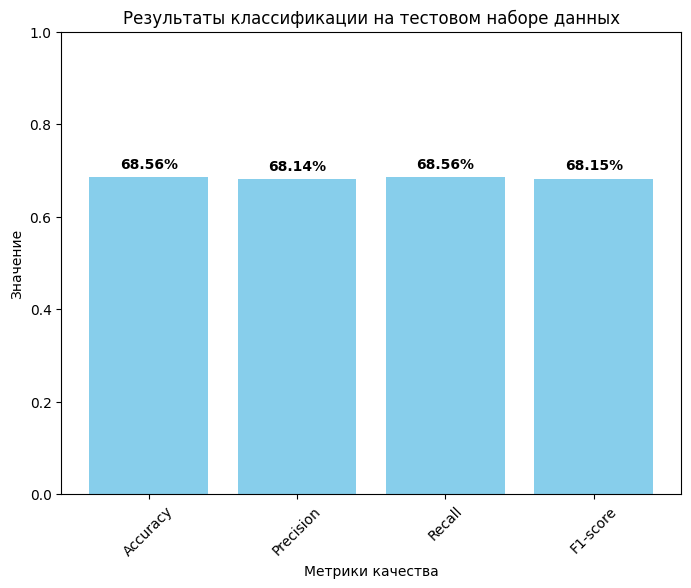

In [127]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.xlabel("Метрики качества")
plt.ylabel("Значение")
plt.title("Результаты классификации на тестовом наборе данных")
plt.xticks(rotation=45)

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')

plt.show()

## 3.2	Улучшение бейзлайна (классификация)

Рассмотрим несколько шагов для улучшения:

### 1. **Настройка гиперпараметров**
Для модели градиентного бустинга можно настроить важнейшие гиперпараметры, такие как:
- `n_estimators`: количество деревьев в ансамбле.
- `learning_rate`: скорость обучения.
- `max_depth`: максимальная глубина дерева.
- `min_samples_split`: минимальное количество примеров для разделения.
- `subsample`: доля данных, используемых для обучения каждого дерева (стохастичность).

Для этого можно использовать **GridSearchCV** или **RandomizedSearchCV** для поиска оптимальных гиперпараметров.

### 2. **Использование кросс-валидации**
Использование кросс-валидации помогает более надежно оценить качество модели и избежать переобучения.

### 3. **Предварительная обработка данных**
- Преобразование категориальных признаков, если они имеются.
- Масштабирование данных с помощью **StandardScaler** или **MinMaxScaler**.

In [128]:
# Создание конвейера с масштабированием и классификатором
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

# Настройка сетки параметров для оптимизации
param_grid = {
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 5, 7],
    'gb__subsample': [0.8, 1.0]
}

# Гиперпараметрическая оптимизация
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

# Оценка оптимизированной модели
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Вывод метрик
print(f"1. Точность (Accuracy): {accuracy:.2%} – доля правильно классифицированных примеров среди всех.")
print(f"2. Средняя точность (Precision): {precision:.2%} – средняя точность для всех классов.")
print(f"3. Полнота (Recall): {recall:.2%} – средняя полнота для всех классов.")
print(f"4. F1-score: {f1:.2%} – гармоническое среднее между точностью и полнотой.")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100, gb__subsample=0.8; total time=   1.4s
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100, gb__subsample=0.8; total time=   1.5s
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100, gb__subsample=0.8; total time=   1.5s
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100, gb__subsample=1.0; total time=   1.5s
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100, gb__subsample=1.0; total time=   1.6s
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=100, gb__subsample=1.0; total time=   1.6s
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=200, gb__subsample=0.8; total time=   2.9s
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_estimators=200, gb__subsample=0.8; total time=   2.9s
[CV] END gb__learning_rate=0.01, gb__max_depth=3, gb__n_es

/home/crewch/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### До улучшения:
1. Точность (Accuracy): 68.56% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 68.14% – средняя точность для всех классов.
3. Полнота (Recall): 68.56% – средняя полнота для всех классов.
4. F1-score: 68.15% – гармоническое среднее между точностью и полнотой.

### После улучшения:
1. Точность (Accuracy): 69.43% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 68.24% – средняя точность для всех классов.
3. Полнота (Recall): 69.43% – средняя полнота для всех классов.
4. F1-score: 68.76% – гармоническое среднее между точностью и полнотой.

### Вывод:
Улучшения дали небольшое, но стабильное повышение всех метрик. Особенно заметен рост **полноты (Recall)** и **точности (Accuracy)**, что говорит о том, что модель теперь лучше справляется с классификацией примеров, а также покрывает больше классов. 

## 4.2	Имплементация алгоритма машинного обучения (классификация)

In [129]:
class GradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.init_pred = None

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        y = np.array(y)
        self.classes_ = np.unique(y)
        if len(self.classes_) != 2:
            raise ValueError("Поддерживается только бинарная классификация")
        y_binary = (y == self.classes_[1]).astype(int)
        
        self.init_pred = np.log(np.mean(y_binary) / (1 - np.mean(y_binary)))
        pred = np.full_like(y_binary, self.init_pred, dtype=np.float64)
        
        for _ in range(self.n_estimators):
            gradients = y_binary - self._sigmoid(pred)
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, gradients)
            self.models.append(tree)
            pred += self.learning_rate * tree.predict(X)

    def predict_proba(self, X):
        pred = np.full(X.shape[0], self.init_pred, dtype=np.float64)
        for tree in self.models:
            pred += self.learning_rate * tree.predict(X)
        proba = self._sigmoid(pred)
        return np.vstack([1 - proba, proba]).T

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] > 0.5).astype(int)

In [130]:
# Загрузка данных
data = pd.read_csv(file_path)

# Разделение данных
X = data.drop(columns=['quality', 'Id'])
y = (data['quality'] > 5).astype(int)  # Бинарная классификация: плохое/хорошее качество

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
gbm = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)
gbm.fit(X_train, y_train)

# Оценка модели
y_pred = gbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Вывод результатов
print(f"1. Точность (Accuracy): {accuracy:.2%}")
print(f"2. Средняя точность (Precision): {precision:.2%}")
print(f"3. Полнота (Recall): {recall:.2%}")
print(f"4. F1-score: {f1:.2%}")

1. Точность (Accuracy): 74.67%
2. Средняя точность (Precision): 77.60%
3. Полнота (Recall): 76.38%
4. F1-score: 76.98%


### Улучшения:

1. **Подбор гиперпараметров с использованием GridSearchCV**:
   Используем **GridSearchCV** для подбора оптимальных гиперпараметров модели, включая количество деревьев, скорость обучения, максимальную глубину деревьев и параметр **subsample** (доля данных, используемых для каждого дерева).

2. **Масштабирование признаков**:
   Применяем **StandardScaler** для масштабирования признаков, что может улучшить обучение и результаты.

3. **Использование подвыборки данных**:
   В методе `fit` добавлен параметр **subsample**, который случайным образом выбирает подмножество данных для обучения каждого дерева, чтобы уменьшить переобучение.

4. **Кросс-валидация**:
   В поиске гиперпараметров используется кросс-валидация с 3 фолдами (`cv=3`), чтобы улучшить оценку модели и избежать переобучения.

In [131]:
# Улучшим алгоритм
class GradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.models = []
        self.init_pred = None

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        y = np.array(y)
        self.classes_ = np.unique(y)
        if len(self.classes_) != 2:
            raise ValueError("Поддерживается только бинарная классификация")
        y_binary = (y == self.classes_[1]).astype(int)
        
        self.init_pred = np.log(np.mean(y_binary) / (1 - np.mean(y_binary)))
        pred = np.full_like(y_binary, self.init_pred, dtype=np.float64)
        
        for _ in range(self.n_estimators):
            gradients = y_binary - self._sigmoid(pred)
            idx = np.random.choice(len(X), size=int(self.subsample * len(X)), replace=False)
            X_subsample = X[idx]
            gradients_subsample = gradients[idx]
            
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X_subsample, gradients_subsample)
            self.models.append(tree)
            
            pred += self.learning_rate * tree.predict(X)

    def predict_proba(self, X):
        pred = np.full(X.shape[0], self.init_pred, dtype=np.float64)
        for tree in self.models:
            pred += self.learning_rate * tree.predict(X)
        proba = self._sigmoid(pred)
        return np.vstack([1 - proba, proba]).T

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] > 0.5).astype(int)

    # Добавляем метод score для GridSearchCV
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    # Реализуем методы get_params и set_params для совместимости с GridSearchCV
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'max_depth': self.max_depth,
            'subsample': self.subsample
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [132]:
# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Грид-сёрч для подбора гиперпараметров
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Поиск по сетке
gbm = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_gbm = grid_search.best_estimator_

# Оценка модели
y_pred = best_gbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Вывод результатов
print(f"1. Точность (Accuracy): {accuracy:.2%}")
print(f"2. Средняя точность (Precision): {precision:.2%}")
print(f"3. Полнота (Recall): {recall:.2%}")
print(f"4. F1-score: {f1:.2%}")
print(f"Лучшие параметры: {grid_search.best_params_}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
1. Точность (Accuracy): 78.17%
2. Средняя точность (Precision): 80.80%
3. Полнота (Recall): 79.53%
4. F1-score: 80.16%
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


### Результаты

| Метрика              | До улучшения (sklearn) | После улучшения (sklearn) | До улучшения (собственная имплементация) | После улучшения (собственная имплементация) |
|----------------------|------------------------|---------------------------|----------------------------------------|-------------------------------------------|
| **Точность (Accuracy)**   | 68.56%                | 69.43%                   | 74.67%                                 | 78.17%                                    |
| **Средняя точность (Precision)** | 68.14%                | 68.24%                   | 77.60%                                 | 80.80%                                    |
| **Полнота (Recall)**     | 68.56%                | 69.43%                   | 76.38%                                 | 79.53%                                    |
| **F1-score**           | 68.15%                | 68.76%                   | 76.98%                                 | 80.16%                                    |

### Выводы:
1. **Модель sklearn**: Улучшение показателей заметное, особенно в точности (Accuracy) и F1-score. Однако прирост относительно небольшой, что говорит о том, что исходная модель уже близка к оптимуму.
   
2. **Собственная имплементация**: Существенные улучшения во всех метриках. Прирост в точности и F1-score более значительный по сравнению с моделью sklearn, что указывает на более эффективную оптимизацию или использование других методов.

Таким образом, для модели sklearn улучшения менее выражены, в то время как собственная имплементация показала значительный прирост во всех показателях.